# Project 02 : CNN practice - QuickDraw

To use [QuickDraw Dataset](https://quickdraw.withgoogle.com/#) with a larger dataset to do image classification with CNN.
<br>There are 100 classes and 10k Examples for training and validation.

## Step 1: Prepare the training data
<br>[Loading images from the Quick Draw Dataset 10k examples](https://console.cloud.google.com/storage/browser/quickdraw_dataset/full/numpy_bitmap?pli=1)

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import keras
from keras.utils import multi_gpu_model
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Input
from keras.layers import Conv2D, MaxPooling2D
import keras.backend as K

import tensorflow as tf

import os
import pickle
import numpy as np

In [3]:
print(keras.__version__)
print(tf.__version__)

2.0.8
1.5.0-dev20171026


In [4]:
num_examples_per_class = 10000

classes = ['airplane','alarm clock','ambulance','angel','ant','anvil','apple','axe','banana','bandage','barn','baseball bat','baseball',
           'basket','basketball','bathtub','beach','bear','beard','bed','bee','belt','bicycle','binoculars','birthday cake','blueberry',
           'book','boomerang','bottlecap','bowtie','bracelet','brain','bread','broom','bulldozer','bus','bus','butterfly','cactus','cake',
           'calculator','calendar','camel','camera','campfire','candle','cannon','canoe','car','carrot','cello','computer',
           'cat','chandelier','clock','cloud','coffee cup','compass','cookie','couch','cow','crab','crayon','crocodile','crown',
           'cup','diamond','dog','dolphin','donut','dragon','dresser','drill','drums','duck','dumbbell','ear','elbow',
           'elephant','envelope','eraser','eye','eyeglasses','face','fan','feather','fence','finger','fire hydrant',
           'fireplace','firetruck','fish','flamingo','flashlight','flip flops','floor lamp','flower','flying saucer',
           'foot','fork']

In [5]:
len(classes)

100

## Step 1-1: Load the image data from scratch

(Optional*)Only use if you are downloading the raw data and doing it yourself

In [7]:
#This cell is only if you are loading the data from scratch
# get the data 
quickdraws = [np.load("../../data/{}.npy".format(qdraw))[:num_examples_per_class] for qdraw in classes]

# Concat the arrays together
x_data = np.concatenate(quickdraws,axis=0)

x_data.shape

FileNotFoundError: [Errno 2] No such file or directory: '../../data/airplane.npy'

In [ ]:
np.save('x_data_100_classes_10k.npy',x_data)

Use this cell to load the premade datasets

In [6]:
x_data = np.load("./x_data_100_classes_10k.npy")

In [7]:
x_data.shape

(1000000, 784)

Let's make some labels for our data

In [8]:
labels = [np.full((num_examples_per_class,), classes.index(qdraw)) for qdraw in classes]

## Concat the arrays together
y_data = np.concatenate(labels,axis=0)
y_data.shape

(1000000,)

let's look at the Images

In [9]:
def show_object(obj):
    # Reshape 784 array into 28x28 image
    image = obj.reshape([28,28])
    fig, axes = plt.subplots(1, )
    fig.subplots_adjust(hspace=0.5, wspace=0.5)
    plt.imshow(image, cmap='gray_r')
    plt.show()

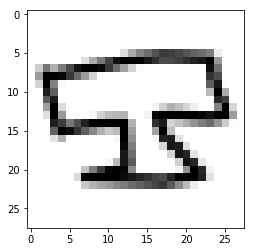

5


In [10]:
show_object(x_data[53000])
print(y_data[53000])

In [11]:
print(x_data.shape)
print(y_data.shape)

(1000000, 784)
(1000000,)


In [12]:
#shuffling function
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

In [13]:
x_data,y_data = unison_shuffled_copies(x_data,y_data)

In [14]:
y_data[0]

6

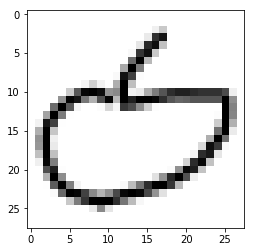

In [15]:
show_object(x_data[0])

## Step 1-2: dataset for training, validation and testing

Set 60% for training data and 20% for validation data and 20% for testing

In [16]:
num_classes = 100
num_of_data = num_classes*10000
num_of_train = int(num_of_data*0.6)
num_of_validition = int(num_of_data*0.8)

In [17]:
x_train = x_data[:num_of_train]
y_train = y_data[:num_of_train]
x_validition = x_data[num_of_train:num_of_validition]
y_validition = y_data[num_of_train:num_of_validition]
x_test = x_data[num_of_validition:]
y_test = y_data[num_of_validition:]

In [18]:
# input image dimensions
img_rows, img_cols = 28, 28

In [19]:
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_validition = x_validition.reshape(x_validition.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_validition = x_validition.reshape(x_validition.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [20]:
x_train = x_train.astype('float32')
x_validition = x_validition.astype("float")
x_test = x_test.astype('float32')

# normalize the data to be the range within [0,1]
x_train /= 255
x_validition /= 255
x_test /= 255

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_validition.shape[0], 'validition samples')
print(x_test.shape[0], 'test samples')

print(y_train.shape, "train labels")
print(num_classes, "classes")

x_train shape: (600000, 28, 28, 1)
600000 train samples
200000 validition samples
200000 test samples
(600000,) train labels
100 classes


In [21]:
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_validition = keras.utils.to_categorical(y_validition, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

### Step 2: Prepare the models

In [22]:
batch_size = 128*16
epochs = 25

In [23]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(num_classes, activation='softmax'))

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

In [24]:
parallel_model = multi_gpu_model(model, gpus=2)
parallel_model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])

In [26]:
history = parallel_model.fit(x_train, y_train,
                          batch_size=batch_size,
                          epochs=epochs,
                          verbose=1,
                          validation_data=(x_validition, y_validition))

Train on 600000 samples, validate on 200000 samples
Epoch 1/25

190464/600000 [========>.....................] - ETA: 12s - loss: 1.2051 - acc: 0.6935


382976/600000 [==================>...........] - ETA: 6s - loss: 1.2116 - acc: 0.6920


577536/600000 [===========================>..] - ETA: 1s - loss: 1.2151 - acc: 0.6915


600000/600000 [==============================] - ETA: 0s - loss: 1.2153 - acc: 0.6913 - val_loss: 0.9868 - val_acc: 0.7547
Epoch 2/25

167936/600000 [=======>......................] - ETA: 12s - loss: 1.2136 - acc: 0.6933


360448/600000 [=================>............] - ETA: 7s - loss: 1.2121 - acc: 0.6929


555008/600000 [==========================>...] - ETA: 1s - loss: 1.2135 - acc: 0.6920


600000/600000 [==============================] - ETA: 0s - loss: 1.2128 - acc: 0.6921 - val_loss: 0.9841 - val_acc: 0.7559
Epoch 3/25

145408/600000 [======>.......................] - ETA: 13s - loss: 1.1997 - acc: 0.6943


337920/600000 [===============>..............] - ETA: 7s - loss: 1.2007 - acc: 0.6943


532480/600000 [=========================>....] - ETA: 2s - loss: 1.2060 - acc: 0.6932


600000/600000 [==============================] - ETA: 0s - loss: 1.2060 - acc: 0.6933 - val_loss: 0.9812 - val_acc: 0.7561
Epoch 4/25

122880/600000 [=====>........................] - ETA: 14s - loss: 1.1912 - acc: 0.6961


315392/600000 [==============>...............] - ETA: 8s - loss: 1.1956 - acc: 0.6955


509952/600000 [========================>.....] - ETA: 3s - loss: 1.1987 - acc: 0.6947


600000/600000 [==============================] - ETA: 0s - loss: 1.1999 - acc: 0.6944 - val_loss: 0.9807 - val_acc: 0.7561
Epoch 5/25

102400/600000 [====>.........................] - ETA: 14s - loss: 1.1870 - acc: 0.6978


294912/600000 [=============>................] - ETA: 9s - loss: 1.1905 - acc: 0.6963


489472/600000 [=======================>......] - ETA: 3s - loss: 1.1943 - acc: 0.6954


600000/600000 [==============================] - ETA: 0s - loss: 1.1953 - acc: 0.6950 - val_loss: 0.9745 - val_acc: 0.7578
Epoch 6/25

 81920/600000 [===>..........................] - ETA: 14s - loss: 1.1801 - acc: 0.6965


274432/600000 [============>.................] - ETA: 9s - loss: 1.1820 - acc: 0.6972


468992/600000 [======================>.......] - ETA: 4s - loss: 1.1882 - acc: 0.6966


600000/600000 [==============================] - ETA: 0s - loss: 1.1915 - acc: 0.6960 - val_loss: 0.9791 - val_acc: 0.7566
Epoch 7/25

 61440/600000 [==>...........................] - ETA: 15s - loss: 1.1805 - acc: 0.6977


253952/600000 [===========>..................] - ETA: 10s - loss: 1.1787 - acc: 0.6981


448512/600000 [=====================>........] - ETA: 4s - loss: 1.1850 - acc: 0.6975


600000/600000 [==============================] - ETA: 0s - loss: 1.1869 - acc: 0.6974 - val_loss: 0.9761 - val_acc: 0.7574
Epoch 8/25

 40960/600000 [=>............................] - ETA: 16s - loss: 1.1580 - acc: 0.7046


233472/600000 [==========>...................] - ETA: 10s - loss: 1.1746 - acc: 0.7002


428032/600000 [====================>.........] - ETA: 5s - loss: 1.1819 - acc: 0.6982


600000/600000 [==============================] - ETA: 0s - loss: 1.1842 - acc: 0.6977 - val_loss: 0.9725 - val_acc: 0.7578
Epoch 9/25

 20480/600000 [>.............................] - ETA: 16s - loss: 1.1354 - acc: 0.7072


212992/600000 [=========>....................] - ETA: 11s - loss: 1.1658 - acc: 0.7019


407552/600000 [===================>..........] - ETA: 5s - loss: 1.1735 - acc: 0.7000


600000/600000 [==============================] - ETA: 0s - loss: 1.1794 - acc: 0.6985 - val_loss: 0.9740 - val_acc: 0.7576
Epoch 10/25



192512/600000 [========>.....................] - ETA: 11s - loss: 1.1686 - acc: 0.7003


385024/600000 [==================>...........] - ETA: 6s - loss: 1.1719 - acc: 0.7000


579584/600000 [===========================>..] - ETA: 1s - loss: 1.1760 - acc: 0.6995


600000/600000 [==============================] - ETA: 0s - loss: 1.1765 - acc: 0.6993 - val_loss: 0.9696 - val_acc: 0.7589
Epoch 11/25

169984/600000 [=======>......................] - ETA: 12s - loss: 1.1620 - acc: 0.7029


362496/600000 [=================>............] - ETA: 7s - loss: 1.1641 - acc: 0.7020


557056/600000 [==========================>...] - ETA: 1s - loss: 1.1686 - acc: 0.7011


600000/600000 [==============================] - ETA: 0s - loss: 1.1699 - acc: 0.7008 - val_loss: 0.9724 - val_acc: 0.7584
Epoch 12/25

147456/600000 [======>.......................] - ETA: 13s - loss: 1.1586 - acc: 0.7032


339968/600000 [===============>..............] - ETA: 7s - loss: 1.1650 - acc: 0.7012


534528/600000 [=========================>....] - ETA: 2s - loss: 1.1686 - acc: 0.7006


600000/600000 [==============================] - ETA: 0s - loss: 1.1693 - acc: 0.7006 - val_loss: 0.9678 - val_acc: 0.7586
Epoch 13/25

124928/600000 [=====>........................] - ETA: 13s - loss: 1.1647 - acc: 0.7023


317440/600000 [==============>...............] - ETA: 8s - loss: 1.1626 - acc: 0.7030


512000/600000 [========================>.....] - ETA: 2s - loss: 1.1640 - acc: 0.7021


600000/600000 [==============================] - ETA: 0s - loss: 1.1647 - acc: 0.7018 - val_loss: 0.9656 - val_acc: 0.7598
Epoch 14/25

104448/600000 [====>.........................] - ETA: 14s - loss: 1.1496 - acc: 0.7054


296960/600000 [=============>................] - ETA: 8s - loss: 1.1511 - acc: 0.7049


491520/600000 [=======================>......] - ETA: 3s - loss: 1.1578 - acc: 0.7032


600000/600000 [==============================] - ETA: 0s - loss: 1.1604 - acc: 0.7028 - val_loss: 0.9665 - val_acc: 0.7591
Epoch 15/25

 83968/600000 [===>..........................] - ETA: 15s - loss: 1.1526 - acc: 0.7037


276480/600000 [============>.................] - ETA: 9s - loss: 1.1525 - acc: 0.7045


471040/600000 [======================>.......] - ETA: 4s - loss: 1.1559 - acc: 0.7038


600000/600000 [==============================] - ETA: 0s - loss: 1.1582 - acc: 0.7033 - val_loss: 0.9708 - val_acc: 0.7585
Epoch 16/25

 63488/600000 [==>...........................] - ETA: 15s - loss: 1.1512 - acc: 0.7046


256000/600000 [===========>..................] - ETA: 10s - loss: 1.1484 - acc: 0.7050


450560/600000 [=====================>........] - ETA: 4s - loss: 1.1534 - acc: 0.7040


600000/600000 [==============================] - ETA: 0s - loss: 1.1561 - acc: 0.7034 - val_loss: 0.9620 - val_acc: 0.7608
Epoch 17/25

 43008/600000 [=>............................] - ETA: 16s - loss: 1.1402 - acc: 0.7075


235520/600000 [==========>...................] - ETA: 10s - loss: 1.1443 - acc: 0.7056


430080/600000 [====================>.........] - ETA: 5s - loss: 1.1511 - acc: 0.7041


600000/600000 [==============================] - ETA: 0s - loss: 1.1535 - acc: 0.7037 - val_loss: 0.9711 - val_acc: 0.7592
Epoch 18/25

 22528/600000 [>.............................] - ETA: 17s - loss: 1.1547 - acc: 0.7050


215040/600000 [=========>....................] - ETA: 11s - loss: 1.1438 - acc: 0.7069


407552/600000 [===================>..........] - ETA: 5s - loss: 1.1458 - acc: 0.7056


600000/600000 [==============================] - ETA: 0s - loss: 1.1519 - acc: 0.7044 - val_loss: 0.9614 - val_acc: 0.7610
Epoch 19/25



192512/600000 [========>.....................] - ETA: 12s - loss: 1.1416 - acc: 0.7056


385024/600000 [==================>...........] - ETA: 6s - loss: 1.1438 - acc: 0.7056


579584/600000 [===========================>..] - ETA: 1s - loss: 1.1480 - acc: 0.7052


600000/600000 [==============================] - ETA: 0s - loss: 1.1484 - acc: 0.7052 - val_loss: 0.9571 - val_acc: 0.7618
Epoch 20/25

169984/600000 [=======>......................] - ETA: 12s - loss: 1.1359 - acc: 0.7065


362496/600000 [=================>............] - ETA: 7s - loss: 1.1436 - acc: 0.7057


557056/600000 [==========================>...] - ETA: 1s - loss: 1.1456 - acc: 0.7051


600000/600000 [==============================] - ETA: 0s - loss: 1.1461 - acc: 0.7050 - val_loss: 0.9628 - val_acc: 0.7600
Epoch 21/25

147456/600000 [======>.......................] - ETA: 13s - loss: 1.1409 - acc: 0.7052


339968/600000 [===============>..............] - ETA: 7s - loss: 1.1410 - acc: 0.7067


534528/600000 [=========================>....] - ETA: 2s - loss: 1.1435 - acc: 0.7062


600000/600000 [==============================] - ETA: 0s - loss: 1.1444 - acc: 0.7060 - val_loss: 0.9587 - val_acc: 0.7612
Epoch 22/25

124928/600000 [=====>........................] - ETA: 14s - loss: 1.1339 - acc: 0.7060


317440/600000 [==============>...............] - ETA: 8s - loss: 1.1375 - acc: 0.7065


512000/600000 [========================>.....] - ETA: 2s - loss: 1.1408 - acc: 0.7062


600000/600000 [==============================] - ETA: 0s - loss: 1.1396 - acc: 0.7066 - val_loss: 0.9604 - val_acc: 0.7608
Epoch 23/25

104448/600000 [====>.........................] - ETA: 14s - loss: 1.1213 - acc: 0.7093


296960/600000 [=============>................] - ETA: 9s - loss: 1.1296 - acc: 0.7075


491520/600000 [=======================>......] - ETA: 3s - loss: 1.1372 - acc: 0.7065


600000/600000 [==============================] - ETA: 0s - loss: 1.1391 - acc: 0.7063 - val_loss: 0.9536 - val_acc: 0.7630
Epoch 24/25

 83968/600000 [===>..........................] - ETA: 15s - loss: 1.1244 - acc: 0.7103


276480/600000 [============>.................] - ETA: 9s - loss: 1.1304 - acc: 0.7079


471040/600000 [======================>.......] - ETA: 4s - loss: 1.1324 - acc: 0.7081


600000/600000 [==============================] - ETA: 0s - loss: 1.1345 - acc: 0.7076 - val_loss: 0.9537 - val_acc: 0.7625
Epoch 25/25

 63488/600000 [==>...........................] - ETA: 15s - loss: 1.1201 - acc: 0.7109


256000/600000 [===========>..................] - ETA: 10s - loss: 1.1275 - acc: 0.7091


450560/600000 [=====================>........] - ETA: 4s - loss: 1.1331 - acc: 0.7081


600000/600000 [==============================] - ETA: 0s - loss: 1.1343 - acc: 0.7081 - val_loss: 0.9558 - val_acc: 0.7619


In [28]:
# save the model and weights
model.save('quickdraw_model.h5')
model.save_weights('quickdraw_weightsqd.h5')

In [29]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_train(hist):
    h = hist
    if 'acc' in h:
        meas='acc'
        loc='lower right'
    else:
        meas='loss'
        loc='upper right'
    plt.plot(hist[meas])
    plt.plot(hist['val_'+meas])
    plt.title('model '+meas)
    plt.ylabel(meas)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc=loc)

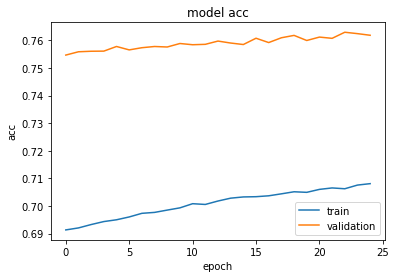

In [31]:
plot_train(parallel_model.history.history)

In [32]:
score = parallel_model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.955510833361
Test accuracy: 0.763365
